# A bird's eye view of optimization


## Math background

### Matrices and vectors

Some `python` subtleties:

- Vectors are always displayed as row (not column) vectors.

- Shape of matrices are tuples of the form `(m,n)`

- Shape of a vector is a tuple of the form `(n,)`

To perform matrix multiplication use `@` not `*`.  The latter performs componentwise multiplication of two matrices of the same size.

In [1]:
import numpy as np
m = 4; n = 3; p = 2
A = np.random.randn(m,n)
B = np.random.randn(n,p)
x = np.random.randn(n)
AB = A@B
Ax = A@x
print("Shape of AB:", AB.shape)
print("Shape of Ax:", Ax.shape)
print("A = \n",A)
print("B = \n",B)
print("AB = \n",AB)
print("Ax = \n",Ax)

Shape of AB: (4, 2)
Shape of Ax: (4,)
A = 
 [[-0.40905089 -1.5339675   1.37578136]
 [ 1.34752229 -1.01592351 -0.48928441]
 [-0.54411782 -1.13223244 -1.10558728]
 [-3.03465889 -0.59282893  0.69472481]]
B = 
 [[-0.97550735  0.85399079]
 [ 0.81649395 -0.00844761]
 [ 1.51304297 -0.73453013]]
AB = 
 [[ 1.22817329 -1.34692018]
 [-2.88432165  1.5187479 ]
 [-2.06647106  0.35698022]
 [ 3.52743933 -3.09685906]]
Ax = 
 [ 2.30151506  2.85353571  0.5182528  -2.45285355]


## Products of vectors

Suppose $a,b\in \mathbb{R}^n$.  

To compute $a^T b \in \mathbb{R}$ use `np.dot()` or `np.inner()`.

To compute $a b^T\in \mathbb{R}^{n\times n}$ use `np.outer()`.

In [2]:
a=np.random.randn(3); b=np.random.randn(3); 
print("a = ", a)
print("b = ", b)
print("a*b = ", a*b)
print("np.dot(a,b) = ", np.dot(a,b))
print("np.inner(a,b) = ", np.inner(a,b))
print("np.outer(a,b) = \n", np.outer(a,b))

a =  [-0.15692671 -0.22871323  0.52417255]
b =  [-0.2262297  -0.73272315 -1.83775532]
a*b =  [ 0.03550148  0.16758348 -0.96330089]
np.dot(a,b) =  -0.7602159311559478
np.inner(a,b) =  -0.7602159311559478
np.outer(a,b) = 
 [[ 0.03550148  0.11498383  0.2883929 ]
 [ 0.05174173  0.16758348  0.42031895]
 [-0.1185834  -0.38407336 -0.96330089]]


## Calculus

Class of least-squares functions of the form $\frac{1}{2}\|Ax-b\|_2^2$.

In [3]:
class LeastSquares:
    """
    f(x) = 0.5*\| A*x - b \|^2 
    """
    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.m = A.shape[0]
        self.n = A.shape[1]
        
    def __call__(self, x):
        f,_ = self.func_grad(x) ; return f
                
    def func_grad(self, x):
        assert x.size == self.n, "LeastSquares: x.size not equal to n"
        Axb = self.A@x - self.b            
        f = 0.5*np.dot(Axb.T,Axb)
        g = self.A.T@Axb
        return f,g


Create an instance of a least-squares function and verify Taylor's first-order approximation.

In [4]:
m = 5 ; n = 3
A = np.random.randn(m,n) ; b = np.random.randn(m) 
f = LeastSquares(A,b)    
x = np.random.randn(n)
fx,gx = f.func_grad(x)
p = 0.1*np.random.randn(n)
print("Taylor approx at x+p = ",fx+np.dot(gx,p) )
print("Function value at x+p = ",f(x+p) )


Taylor approx at x+p =  5.574009332239666
Function value at x+p =  5.576203716923034


## Unconstrained optimization

We can minimize $\frac{1}{2} \|Ax-b\|_2^2$  via Fermat's rule: $\bar x = (A^TA)^{-1}A^Tb$ or via `cxvpy`. 

In [5]:
m = 5 ; n = 3
A = np.random.randn(m,n) ; b = np.random.randn(m) 
ATA = A.T@A
ATb = A.T@b
x = np.linalg.solve(ATA,ATb)
print(x)

[0.4031269  0.50258242 0.24693729]


Set up the problem in `cvxpy`.  For installation instructions and related information on `cvxpy` visit https://www.cvxpy.org

To formulate the problem you need to define variables, objective, and constraints.

In [6]:
# Run the following line if you are using Colab and want to use the fancy solver Gurobi
# !pip install gurobipy
import cvxpy as cp
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b))
prob = cp.Problem(objective)

Next, solve the problem and display the solution.  

We can use the fancy solver `gurobi` if available.  If not, we can use the default solver via `prob.solve()` 

To see all available solvers use `cvxpy.installed_solvers()`

In [7]:
prob.solve(solver=cp.GUROBI)
print(x.value)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
[0.4031269  0.50258242 0.24693729]


As a sanity check, verify that the gradient is indeed zero.

In [8]:
f = LeastSquares(A,b)
fx,gx = f.func_grad(x.value)
print(gx)

[-3.67440325e-13 -4.02280992e-13 -2.67036452e-13]


Repeat the above for $\frac{1}{2} \|Ax-b\|_2^2 + \lambda \|x\|_2^2 $.

In [9]:
lam = 0.1
x = np.linalg.solve(ATA+2*lam*np.identity(n),ATb)
print(x)

[0.39443588 0.47053934 0.22224098]


In [10]:
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.sum_squares(x))
prob = cp.Problem(objective)
prob.solve(solver=cp.GUROBI)
print(x.value)

[0.39443588 0.47053934 0.22224098]


## Linear programming

### Porfolio construction example.

Linear programming model for fund allocation.  We want to solve
$$ 
\begin{array}{rl} \max_x & r^Tx \\
& Ax = b \\
& Dx \ge d\\
& x\ge 0
\end{array}
$$
for $r,A,b,D,d$ as below.

Define the problem data.

In [11]:
n = 4
r = np.array([0.10, 0.15, 0.16, 0.08]) 
A = np.array([1, 1, 1, 1,]) 
b = 80 
D = np.array([[0.5, 0.3, 0.25, 0.6],
              [0.3, 0.1, 0.4,  0.2],
              [0.2, 0.6, 0.35, 0.2]]) 
d = np.array([28,24,12]) 

Set up the problem in `cvxpy`.  

To formulate the problem you need to define variables, objective, and constraints.

In [12]:
import cvxpy as cp
x = cp.Variable(n)
objective = cp.Maximize(r.T@x)
constraints = [A@x == b,D@x>=d, x>=0]
prob = cp.Problem(objective, constraints)

Next, solve the problem.  

We can use the fancy solver `gurobi` if available.  
If not, we can use the default solver via `prob.solve()` 

In [13]:
prob.solve(solver=cp.GUROBI)

10.989473684210527

Display optimal value and optimal solution.  

In [14]:
print("\nThe optimal value is", prob.value)
print("An optimal solution is")
print(x.value)


The optimal value is 10.989473684210527
An optimal solution is
[ 0.         12.63157895 46.31578947 21.05263158]


As a sanity check, verify that the constraints hold.

In [15]:
print("Ax = ",A@x.value)
print("Dx = ",D@x.value)

Ax =  80.0
Dx =  [28. 24. 28.]


## Transportation problem

Create an example of a transportation problem.  To make things simple, construct an instance as follows:

- The number of sources and of destinations are the same.

- All supplies and demands are equal to one.

In this case the transportation problem becomes an *assignment* problem: we want to assign sources to destination in some optimal (low cost) way.

In [16]:
n = 5
c = np.round(100*np.random.rand(5,5))
c

array([[21., 91., 57., 16., 80.],
       [ 4., 57., 77., 36., 65.],
       [20.,  0., 42., 45., 62.],
       [64., 75., 62., 57., 46.],
       [78., 60., 85., 81., 34.]])

In [17]:
x = cp.Variable((n,n))
objective = cp.Minimize(cp.trace(c.T@x))
constraints = [x>=0]
constraints += [
    cp.sum(x[:,i])==1 for i in range(n)
]
constraints += [
    cp.sum(x[j,:])==1 for j in range(n)
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GUROBI)


116.0

In [18]:
print(x.value)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


## $\ell_1$ minimization

The $\ell_1$ minimization problem to find a sparse solution to $Ax=b$.

First generate $A,b$ such that $Ax=b$ has a sparse solution.

In [19]:
n = 40; k = 5; m = 20
y = np.random.rand(n)
ysort = np.sort(y)
ysort[-k]
y = y*(y>=ysort[-k])
A = np.random.randn(m,n)
b = A@y

In [20]:
x = cp.Variable(n)
u = cp.Variable(n)
objective = cp.Minimize(cp.sum(u))
constraints = [A@x==b, x<=u, -x<=u]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GUROBI)

4.697262822754393

In many cases we recover the original sparse $y$ solution.

norm of the difference =  1.683736582170148e-15


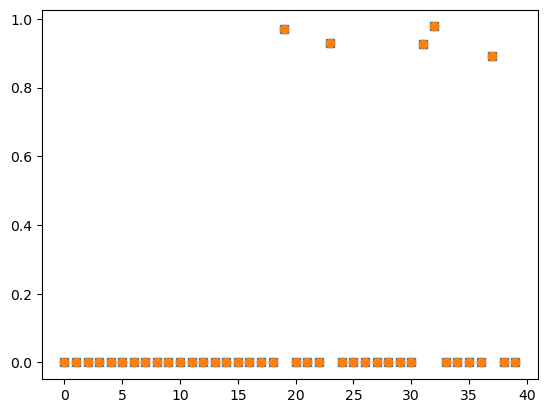

In [21]:
import matplotlib.pyplot as plt

print("norm of the difference = ", np.linalg.norm(y-x.value))
plt.plot(y,'s') ; plt.plot(x.value,'o')

`cvxpy` also allows us to formulate the $\ell_1$ minimization directly via the `cp.norm` function.

norm of the difference =  1.683736582170148e-15


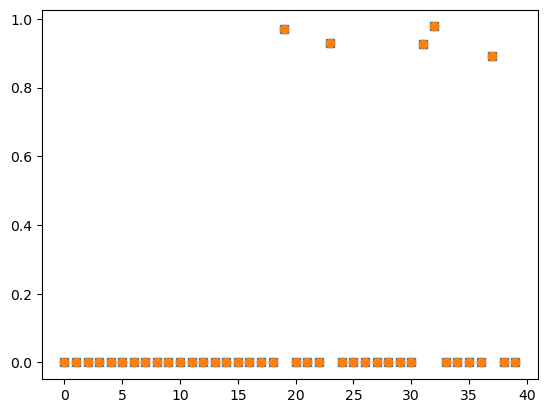

In [22]:
x = cp.Variable(n)
objective = cp.Minimize(cp.norm(x,1))
constraints = [A@x==b]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GUROBI)
print("norm of the difference = ", np.linalg.norm(y-x.value))
plt.plot(y,'s') ; plt.plot(x.value,'o')

## Lasso regression

In general, the lasso model $\min_x \left\{ \frac{1}{2}\|Ax-b\|_2^2 + \lambda \cdot \|x\|_1\right\}$ can only be solved numerically.

First generate $A\in \mathbb{R}^{m\times n}, b\in\mathbb{R}^m$.  To make it more interesting, pick $n > m$.


In [23]:
m=50; n=100
A = np.random.randn(m,n)
b = np.random.randn(m)

Now solve the lasso model.

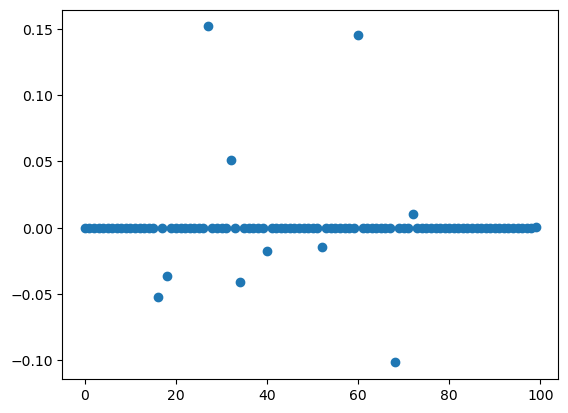

In [24]:
lam = 10
x = cp.Variable(n)
u = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.sum(u))
constraints = [x<=u, -x<=u]
prob = cp.Problem(objective,constraints)
prob.solve()
plt.plot(x.value,'o')

Again, `cvxpy` allows us to formulate the $\ell_1$ minimization directly.

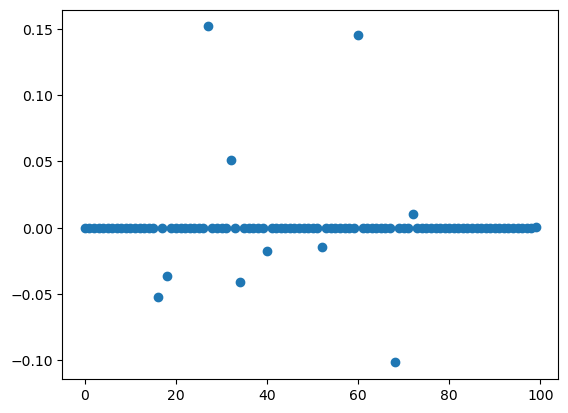

In [25]:
x = cp.Variable(n)
objective = cp.Minimize(0.5*cp.sum_squares(A@x-b)+lam*cp.norm(x,1))
prob = cp.Problem(objective)
prob.solve(solver=cp.GUROBI)
plt.plot(x.value,'o')

## Mean-variance models

Suppose asset returns follow a one-factor model: $r_i = \beta_i \cdot f + u_i$ for $i=1,\dots,n$.


In [26]:
n = 5
beta = 0.5 + np.arange(n)/(n-1)
V = np.outer(beta,beta)+np.identity(n)
mu = 0.1*beta

First find fully-invested, long-only, portfolio of minimum variance, that is,
$$
\begin{array}{rl}
min_x & x^TVx \\
& 1^Tx = 1\\
& x\ge 0.
\end{array}
$$

As you may intuit, the portfolio is tilted toward low beta assets.

Text(0, 0.5, 'asset holdings')

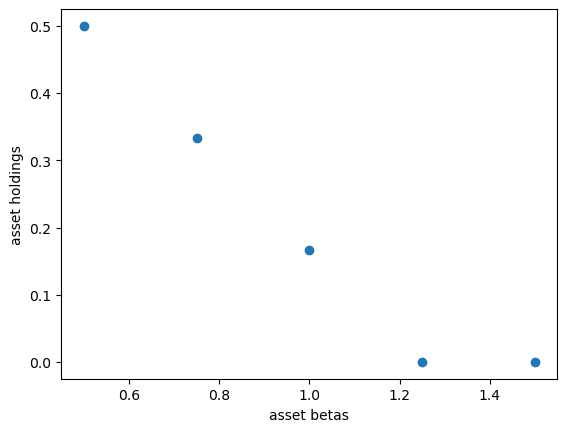

In [27]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x,V))
constraints = [cp.sum(x)==1, x>=0]
prob = cp.Problem(objective,constraints)
prob.solve(solver=cp.GUROBI)
fig, ax = plt.subplots()
ax.plot(beta,x.value,'o')
ax.set_xlabel("asset betas")
ax.set_ylabel("asset holdings")

Next, find fully-invested, long-only, efficient portfolio for some risk aversion $\gamma>0:$

$$
\begin{array}{rl}
min_x & \frac{\gamma}{2} x^TVx - \mu^T x\\
& 1^Tx = 1\\
& x\ge 0.
\end{array}
$$

For small $\gamma$ the portfolio is tilted toward large beta assets. 

Text(0, 0.5, 'asset holdings')

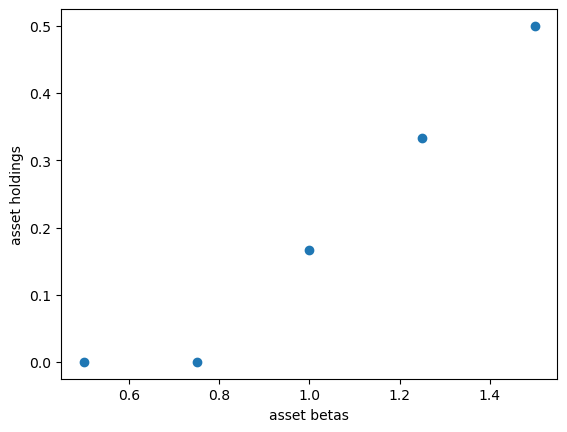

In [28]:
x = cp.Variable(n)
gamma = 0.05
objective = cp.Minimize(0.5*gamma*cp.quad_form(x,V)-mu.T@x)
constraints = [cp.sum(x)==1, x>=0]
prob = cp.Problem(objective,constraints)
prob.solve(solver=cp.GUROBI)
fig, ax = plt.subplots()
ax.plot(beta,x.value,'o')
ax.set_xlabel("asset betas")
ax.set_ylabel("asset holdings")

Now generate and visualize a bunch of portfolios on the efficient frontier.

In [29]:
N = 20
gammamin = sum(np.linalg.solve(V,mu))/5
gammamax = sum(np.linalg.solve(V,mu))*100
gamma = 1/np.linspace(1/gammamax,1/gammamin,N)
sigmafrontier = np.zeros(N)
mufrontier = np.zeros(N)

xfrontier = np.empty((n,N))
for k in range(N):
    x = cp.Variable(n)
    objective = cp.Minimize(0.5*gamma[k]*cp.quad_form(x,V)-mu.T@x)
    constraints = [cp.sum(x)==1, x>=0]
    prob = cp.Problem(objective,constraints)
    prob.solve(solver=cp.GUROBI)
    xfrontier[:,k] = x.value
    mufrontier[k] = mu.T@x.value
    sigmafrontier[k] = (x.value.T@V@x.value)**0.5

Visualize the efficient frontier: the holdings of the efficient portfolios.

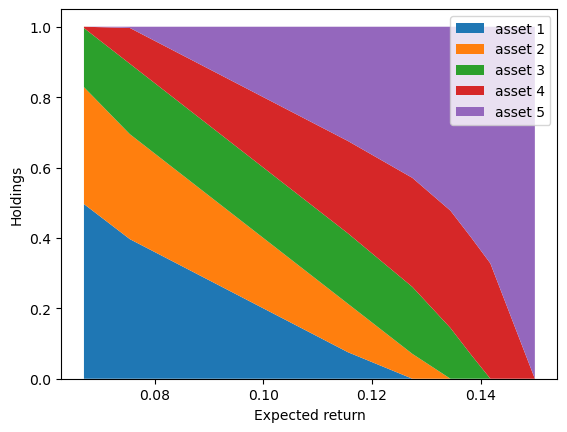

In [30]:
names = list(map(lambda x: 'asset '+str(x),np.arange(n)+1))
fig, ax = plt.subplots()
ax.stackplot(mufrontier,xfrontier,labels=names)
ax.set_xlabel("Expected return")
ax.set_ylabel("Holdings")
plt.legend()

Visualize also the $\mu$ versus $\sigma$ plot for portfolios on the efficient frontier.

Text(0, 0.5, 'Expected return')

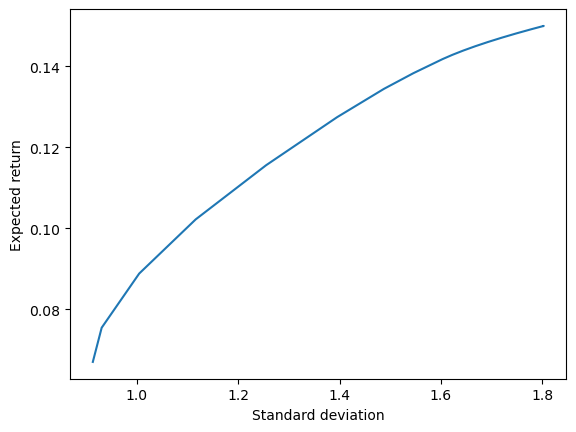

In [31]:
fig,ax = plt.subplots()
ax.plot(sigmafrontier,mufrontier)
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Expected return")

## Integer programming

In [32]:
w = np.array([7,10,6,3]) 
v = np.array([9,11,7,4])
W = 19

In [33]:
n = len(v)
x = cp.Variable(n,boolean=True)
prob = cp.Problem(cp.Maximize(v.T@x),
                 [w.T@x <= W])
prob.solve(solver=cp.GUROBI)
print(x.value)

[0. 1. 1. 1.]


In [34]:
n = 100
v = np.round(100*np.random.rand(n))
w = np.round(100*np.random.rand(n))
W = np.sum(w)//2
n = len(v)
x = cp.Variable(n,boolean=True)
prob = cp.Problem(cp.Maximize(v.T@x),
                 [w.T@x <= W])
prob.solve(solver=cp.GUROBI)
print('Number of selected items = ', np.sum(x.value>0))

Number of selected items =  62


Here is a mixed integer programming formulation for benchmark tracking tested on randomly generated instances.  Observe that the problem can be easily solved for  $n\le 30$ but it becomes much more challenging for larger values of $n$.

In [35]:
n = 20
k = n//2
L = np.random.randn(n,n)
V = L@L.T
x = cp.Variable(n)
xB = np.ones(n)/n
y = cp.Variable(n,boolean=True)
obj = cp.Minimize(cp.quad_form(x-xB,V))
constraints = [cp.sum(x)==1,x>=0,x<=y,cp.sum(y)<=10]
prob = cp.Problem(obj,constraints)
prob.solve(solver=cp.GUROBI)
print('Number of nonzero holdings = ', np.sum(x.value>0))

Number of nonzero holdings =  10
